In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
%matplotlib inline

The dataset was downloaded from https://data.mendeley.com/datasets/th422bg4yd/1. The zip file contain two seprated zip file: WheatLeafRust.zip and Ndeficient.zip. After unzipping, I combined the control from WheatLeafRust, diseased from WheatLeafRust and deficiency from Ndeficient together and named the whole folder as "dataset".

train dataset contains 343 images for control samples


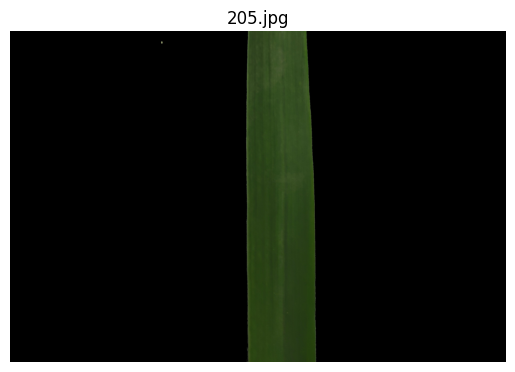

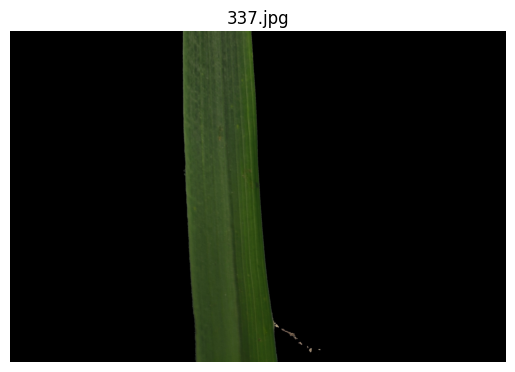

train dataset contains 210 images for deficiency samples


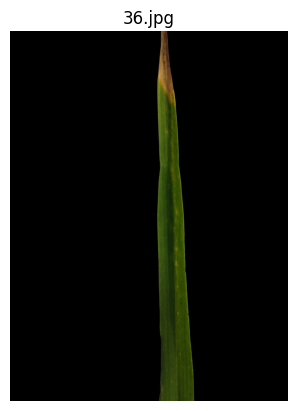

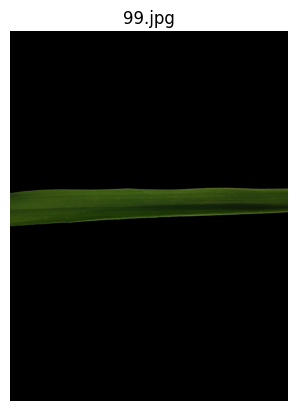

train dataset contains 258 images for diseased samples


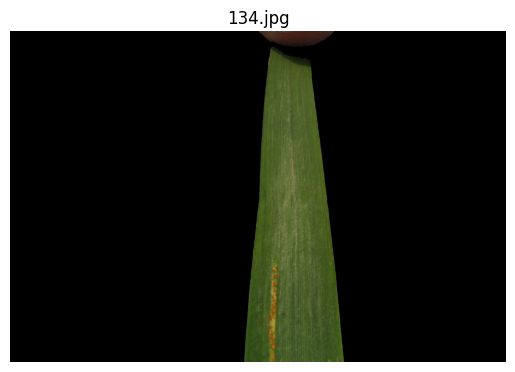

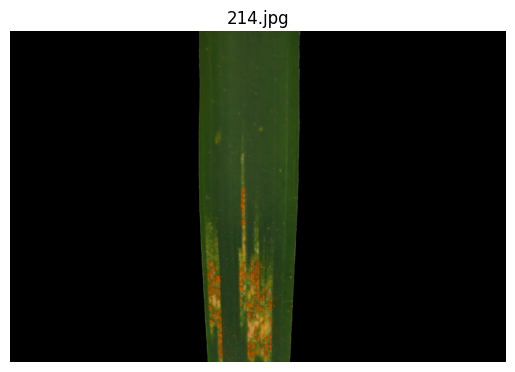

val dataset contains 74 images for control samples


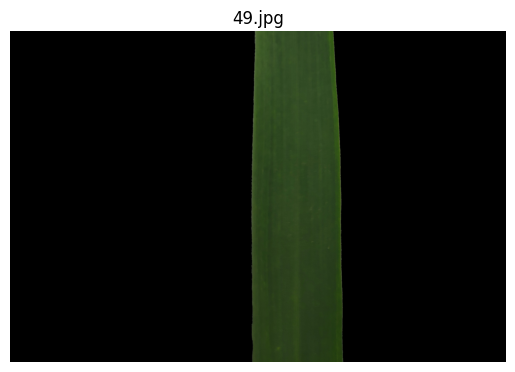

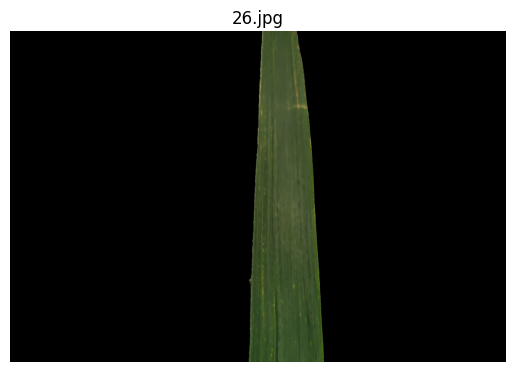

val dataset contains 45 images for deficiency samples


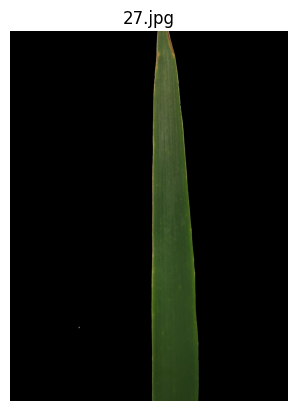

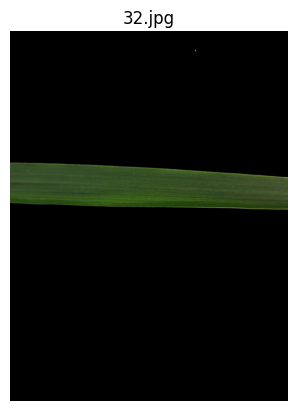

val dataset contains 55 images for diseased samples


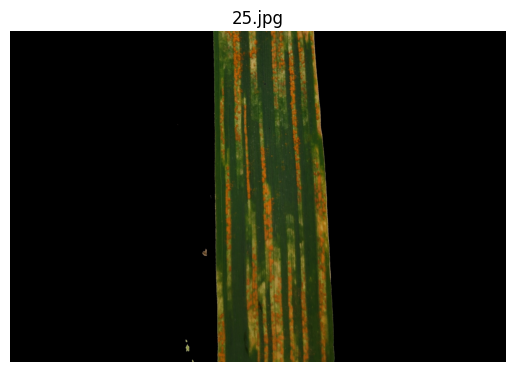

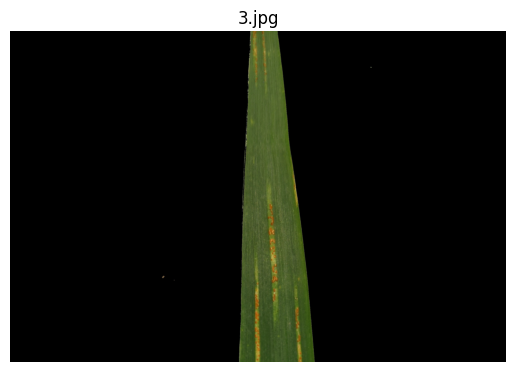

test dataset contains 74 images for control samples


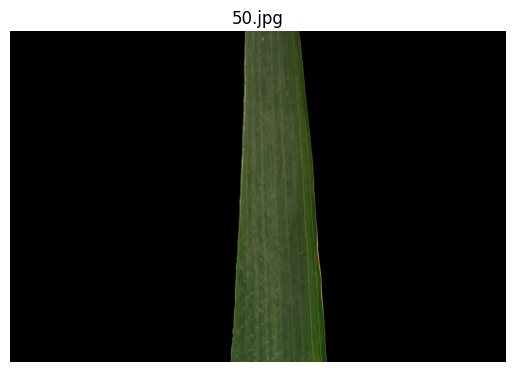

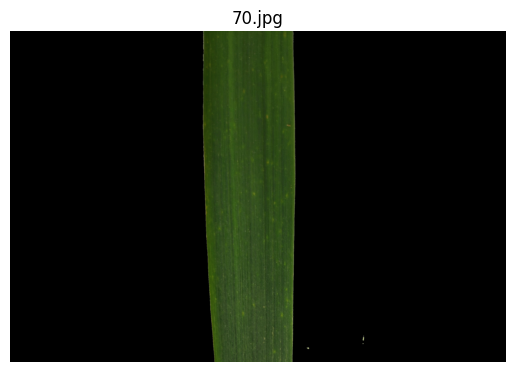

test dataset contains 45 images for deficiency samples


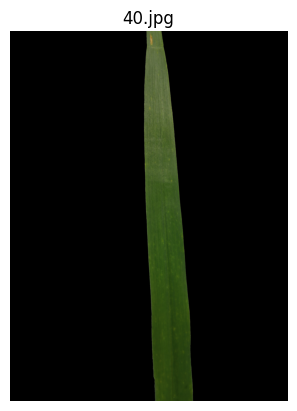

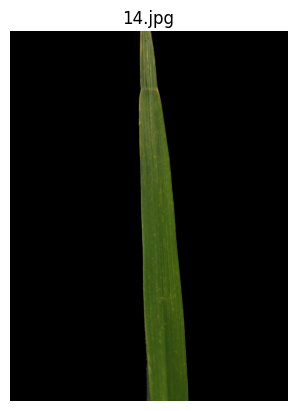

test dataset contains 55 images for diseased samples


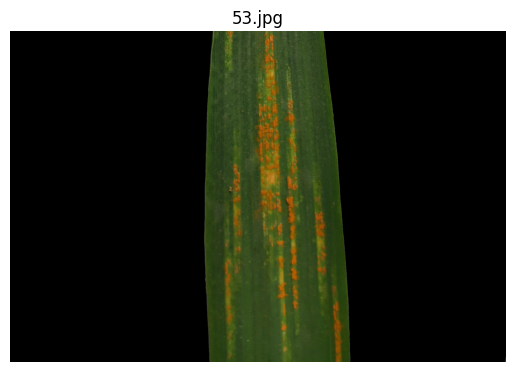

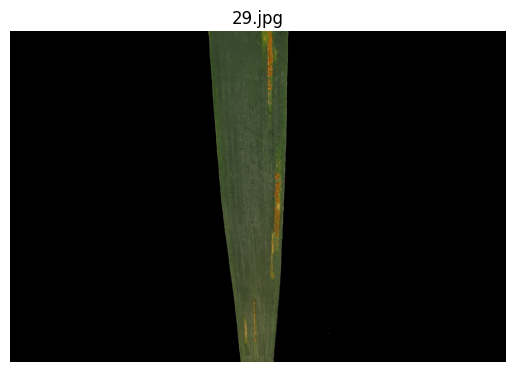

,control,deficiency,diseased
train,343,210,258
val,74,45,55
test,74,45,55


In [95]:
# Display the random samples image of the dataset
root_folder = "/Users/ruiyingliu/Desktop/Final project/dataset/"
number_image_lst = []

for folder in ['train', 'val', 'test']:
    for subfolder in ['control', 'deficiency','diseased']:
        current_folder = os.path.join(root_folder, folder, subfolder)
        for file in os.listdir(current_folder):
            file_dir = os.path.join(current_folder, file)
            image_files = [img for img in os.listdir(current_folder)]
            selected_images = random.sample(image_files, 2)
        print(f"{folder} dataset contains {len(image_files)} images for {subfolder} samples")
        number_image_lst.append(len(image_files))

        for file in selected_images:
            path = os.path.join(current_folder, file)
            image = Image.open(path)
            image = Image.open(path)
            plt.imshow(image)
            plt.title(os.path.basename(path))
            plt.axis('off') 
            plt.show()
num_images_arr = np.array(number_image_lst).reshape(3, 3)
num_images_df = pd.DataFrame(num_images_arr, index = ['train', 'val', 'test'], columns = ['control', 'deficiency','diseased'])
num_images_df


In [2]:
# Identifying the directiory with training, test and validation images

train_dir =  '/Users/ruiyingliu/Desktop/Final project/dataset/train'
val_dir = '/Users/ruiyingliu/Desktop/Final project/dataset/val'
test_dir = '/Users/ruiyingliu/Desktop/Final project/dataset/test'

In [3]:
# Set the parameters
image_size = (150, 150)
batch_size = 32
input_shape = (150, 150, 3)
num_classes = 3

In [4]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import svm
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers, models, regularizers

In [5]:
# load data
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical' 
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 811 images belonging to 3 classes.
Found 174 images belonging to 3 classes.
Found 174 images belonging to 3 classes.


In [7]:
# model1: SVM model
# Obtain train set feature vectors and labels
train_features = []
train_labels = []
for i in range(len(train_generator)):
    batch_images, batch_labels = train_generator[i]
    for image in batch_images:
        train_features.append(image.flatten())  
    train_labels.extend(batch_labels)
train_features = np.array(train_features)
train_labels = np.argmax(train_labels, axis = 1)

# Obtain validation set feature vectors and labels
val_features = []
val_labels = []
for i in range(len(val_generator)):
    batch_images, batch_labels = val_generator[i]
    for image in batch_images:
        val_features.append(image.flatten())  
    val_labels.extend(batch_labels)
val_features = np.array(val_features)
val_labels = np.argmax(val_labels, axis = 1)

# Train SVM model

svm_model = svm.SVC(kernel='linear')  
svm_model.fit(train_features, train_labels)

# Model evaluation
train_pred = svm_model.predict(train_features)
train_accuracy = accuracy_score(train_labels, train_pred)
val_pred = svm_model.predict(val_features)
val_accuracy = accuracy_score(val_labels, val_pred)
print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)


Train Accuracy: 1.0
Validation Accuracy: 0.8735632183908046


In [11]:
# model 2: initial cnn

model2 = tf.keras.Sequential(
        [
        tf.keras.layers.Convolution2D(32, kernel_size=5, input_shape=input_shape, activation=tf.keras.activations.relu, padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Convolution2D(32, kernel_size=4, activation=tf.keras.activations.relu, padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Convolution2D(32, kernel_size=3, activation=tf.keras.activations.relu),
        
        # flatten the entire "cube"
        tf.keras.layers.Flatten(),
        
        # add a drop out layers with probability of 0.1
        tf.keras.layers.Dropout(rate=0.2),
       
        tf.keras.layers.Dense(3, activation='softmax'),
    ]
)


model2.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 32)        16416     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 35, 35, 32)        9248      
                                                                 
 flatten_1 (Flatten)         (None, 39200)            

In [12]:
# model 2: initial cnn

history2 = model2.fit(train_generator, validation_data=val_generator,  batch_size=batch_size, epochs=80, verbose=1)


Epoch 1/80
26/26 [==============================] - 38s 1s/step - loss: 0.9347 - accuracy: 0.5388 - val_loss: 0.6807 - val_accuracy: 0.7644
Epoch 2/80
26/26 [==============================] - 37s 1s/step - loss: 0.5415 - accuracy: 0.7805 - val_loss: 0.4174 - val_accuracy: 0.8448
Epoch 3/80
26/26 [==============================] - 37s 1s/step - loss: 0.3117 - accuracy: 0.8878 - val_loss: 0.4397 - val_accuracy: 0.8563
Epoch 4/80
26/26 [==============================] - 37s 1s/step - loss: 0.2319 - accuracy: 0.9162 - val_loss: 0.2746 - val_accuracy: 0.9253
Epoch 5/80
26/26 [==============================] - 37s 1s/step - loss: 0.1651 - accuracy: 0.9334 - val_loss: 0.3065 - val_accuracy: 0.9195
Epoch 6/80
26/26 [==============================] - 37s 1s/step - loss: 0.1290 - accuracy: 0.9544 - val_loss: 0.4061 - val_accuracy: 0.8908
Epoch 7/80
26/26 [==============================] - 37s 1s/step - loss: 0.1103 - accuracy: 0.9605 - val_loss: 0.3263 - val_accuracy: 0.9138
Epoch 8/80
26/26 [==

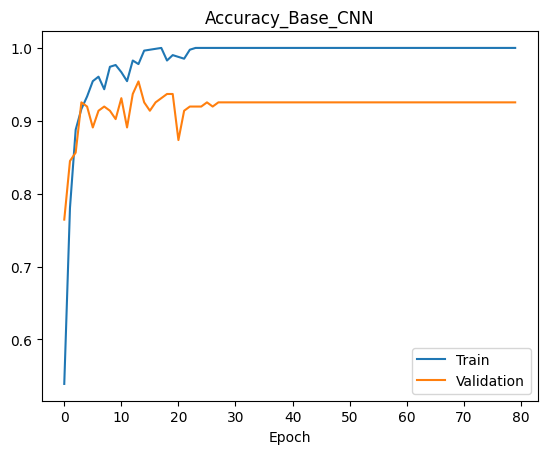

In [28]:
# model 2: initial cnn
# accuracy curve

# plt.style.use('seaborn-whitegrid')
plt.plot(history2.history['accuracy'], label='Train')
plt.plot(history2.history['val_accuracy'], label='Validation')
plt.title('Accuracy_Base_CNN')
plt.xlabel('Epoch')
plt.legend()
plt.show()

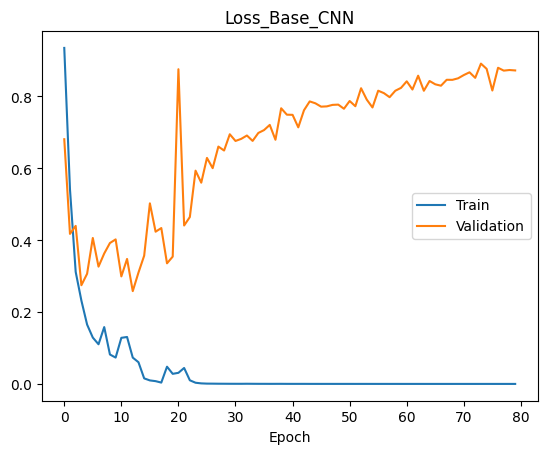

In [30]:
# model 2: initial cnn
# loss curve

plt.plot(history2.history['loss'], label='Train')
plt.plot(history2.history['val_loss'], label='Validation')
plt.title('Loss_Base_CNN')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [6]:
# model 3: regularization
from tensorflow.keras import regularizers

model3 = tf.keras.Sequential([
    tf.keras.layers.Convolution2D(32, kernel_size=5, input_shape=input_shape, activation=tf.keras.activations.relu, padding='same', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Convolution2D(32, kernel_size=4, activation=tf.keras.activations.relu, padding='same', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Convolution2D(32, kernel_size=3, activation=tf.keras.activations.relu, kernel_regularizer=regularizers.l2(0.01)),
    
    # Flatten the entire "cube"
    tf.keras.layers.Flatten(),
    
    # Add a dropout layer with probability of 0.2
    tf.keras.layers.Dropout(rate=0.2),
   
    tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.01)),
])

model3.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        16416     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 35, 35, 32)        9248      
                                                                 
 flatten (Flatten)           (None, 39200)             0

In [8]:
# model 3: regularization
history3 = model2.fit(train_generator, validation_data=val_generator,  batch_size=batch_size, epochs=80, verbose=1)

Epoch 1/80
26/26 [==============================] - 37s 1s/step - loss: 1.5004 - accuracy: 0.5573 - val_loss: 1.2690 - val_accuracy: 0.5115
Epoch 2/80
26/26 [==============================] - 37s 1s/step - loss: 0.9885 - accuracy: 0.7583 - val_loss: 0.9666 - val_accuracy: 0.7356
Epoch 3/80
26/26 [==============================] - 36s 1s/step - loss: 0.8172 - accuracy: 0.7928 - val_loss: 0.8693 - val_accuracy: 0.7644
Epoch 4/80
26/26 [==============================] - 36s 1s/step - loss: 0.7092 - accuracy: 0.8508 - val_loss: 0.8370 - val_accuracy: 0.8161
Epoch 5/80
26/26 [==============================] - 36s 1s/step - loss: 0.5725 - accuracy: 0.9137 - val_loss: 0.6335 - val_accuracy: 0.8678
Epoch 6/80
26/26 [==============================] - 36s 1s/step - loss: 0.4873 - accuracy: 0.9334 - val_loss: 0.5605 - val_accuracy: 0.8851
Epoch 7/80
26/26 [==============================] - 36s 1s/step - loss: 0.5158 - accuracy: 0.9174 - val_loss: 0.5797 - val_accuracy: 0.9023
Epoch 8/80
26/26 [==

In [9]:
# model 3: regularization
# continue training and add additional epoches
history3_additional = model3.fit(train_generator, 
                                validation_data=val_generator, 
                                batch_size=batch_size, 
                                epochs=20, 
                                verbose=1)


Epoch 1/20
26/26 [==============================] - 38s 1s/step - loss: 0.2032 - accuracy: 0.9877 - val_loss: 0.2838 - val_accuracy: 0.9770
Epoch 2/20
26/26 [==============================] - 37s 1s/step - loss: 0.2212 - accuracy: 0.9827 - val_loss: 0.3002 - val_accuracy: 0.9540
Epoch 3/20
26/26 [==============================] - 37s 1s/step - loss: 0.2061 - accuracy: 0.9840 - val_loss: 0.2931 - val_accuracy: 0.9598
Epoch 4/20
26/26 [==============================] - 37s 1s/step - loss: 0.1994 - accuracy: 0.9877 - val_loss: 0.3568 - val_accuracy: 0.9425
Epoch 5/20
26/26 [==============================] - 37s 1s/step - loss: 0.2067 - accuracy: 0.9852 - val_loss: 0.2761 - val_accuracy: 0.9770
Epoch 6/20
26/26 [==============================] - 37s 1s/step - loss: 0.2086 - accuracy: 0.9827 - val_loss: 0.2702 - val_accuracy: 0.9770
Epoch 7/20
26/26 [==============================] - 37s 1s/step - loss: 0.2033 - accuracy: 0.9840 - val_loss: 0.3100 - val_accuracy: 0.9483
Epoch 8/20
26/26 [==

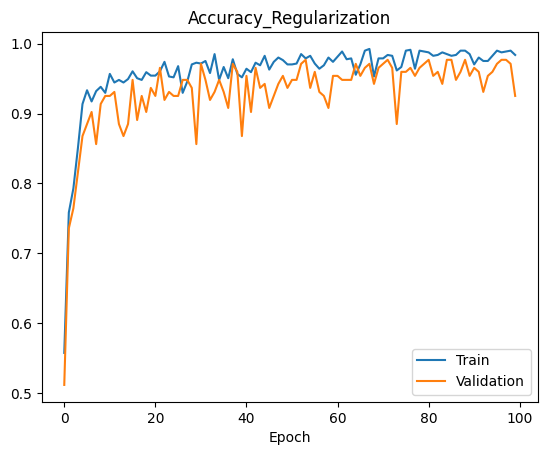

In [12]:
# model 3: regularization
# accuracy curve

# plt.style.use('seaborn-whitegrid')

train_accuracy_combined = history3.history['accuracy'] + history3_additional.history['accuracy']
val_accuracy_combined = history3.history['val_accuracy'] + history3_additional.history['val_accuracy'] 
plt.plot(train_accuracy_combined , label='Train')
plt.plot(val_accuracy_combined, label='Validation')
plt.title('Accuracy_Regularization')
plt.xlabel('Epoch')
plt.legend()
plt.show()

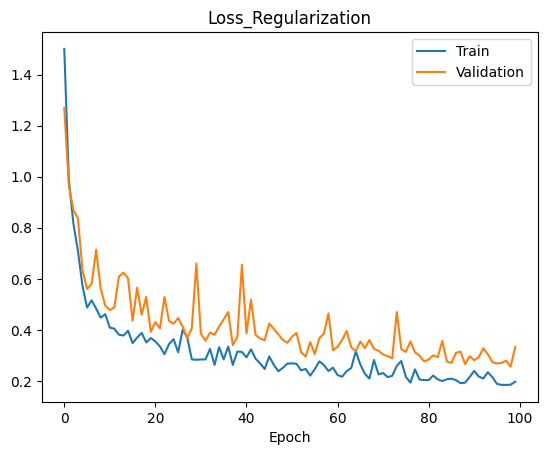

In [13]:
# model 3: regularization
# loss curve

# plt.style.use('seaborn-whitegrid')

train_loss_combined = history3.history['loss'] + history3_additional.history['loss']
val_loss_combined = history3.history['val_loss'] + history3_additional.history['val_loss']
plt.plot(train_loss_combined , label='Train')
plt.plot(val_loss_combined, label='Validation')
plt.title('Loss_Regularization')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [7]:
# model 4: add Image augmentation
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Image data generators
train_generator_aug = train_datagen_aug.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 811 images belonging to 3 classes.


In [15]:
# model 4: add Image augmentation

history4 = model2.fit(train_generator_aug, validation_data=val_generator,  batch_size=batch_size, epochs=80, verbose=1)


Epoch 1/80
26/26 [==============================] - 39s 2s/step - loss: 1.0689 - accuracy: 0.6856 - val_loss: 0.2874 - val_accuracy: 0.9310
Epoch 2/80
26/26 [==============================] - 39s 1s/step - loss: 0.4408 - accuracy: 0.8446 - val_loss: 0.1919 - val_accuracy: 0.9253
Epoch 3/80
26/26 [==============================] - 38s 1s/step - loss: 0.3957 - accuracy: 0.8668 - val_loss: 0.2799 - val_accuracy: 0.8793
Epoch 4/80
26/26 [==============================] - 38s 1s/step - loss: 0.3483 - accuracy: 0.8829 - val_loss: 0.2329 - val_accuracy: 0.9425
Epoch 5/80
26/26 [==============================] - 38s 1s/step - loss: 0.2188 - accuracy: 0.9408 - val_loss: 0.3132 - val_accuracy: 0.8966
Epoch 6/80
26/26 [==============================] - 39s 1s/step - loss: 0.2292 - accuracy: 0.9236 - val_loss: 0.1829 - val_accuracy: 0.9425
Epoch 7/80
26/26 [==============================] - 39s 1s/step - loss: 0.2035 - accuracy: 0.9334 - val_loss: 0.3501 - val_accuracy: 0.9138
Epoch 8/80
26/26 [==

In [17]:
# model 4: add Image augmentation
# continue training and add additional epoches
history4_additional = model2.fit(train_generator_aug, 
                                validation_data=val_generator, 
                                batch_size=batch_size, 
                                epochs=10, 
                                verbose=1)


Epoch 1/10
26/26 [==============================] - 40s 2s/step - loss: 0.0722 - accuracy: 0.9790 - val_loss: 0.1350 - val_accuracy: 0.9770
Epoch 2/10
26/26 [==============================] - 39s 1s/step - loss: 0.0640 - accuracy: 0.9840 - val_loss: 0.1155 - val_accuracy: 0.9828
Epoch 3/10
26/26 [==============================] - 39s 2s/step - loss: 0.0714 - accuracy: 0.9803 - val_loss: 0.2259 - val_accuracy: 0.9540
Epoch 4/10
26/26 [==============================] - 40s 2s/step - loss: 0.0715 - accuracy: 0.9827 - val_loss: 0.1365 - val_accuracy: 0.9770
Epoch 5/10
26/26 [==============================] - 40s 2s/step - loss: 0.1035 - accuracy: 0.9679 - val_loss: 0.1074 - val_accuracy: 0.9598
Epoch 6/10
26/26 [==============================] - 39s 2s/step - loss: 0.0878 - accuracy: 0.9753 - val_loss: 0.1312 - val_accuracy: 0.9655
Epoch 7/10
26/26 [==============================] - 39s 2s/step - loss: 0.0718 - accuracy: 0.9790 - val_loss: 0.1105 - val_accuracy: 0.9770
Epoch 8/10
26/26 [==

In [21]:
# model 4: add Image augmentation
# continue training and add additional epoches
history4_additional2 = model2.fit(train_generator_aug, 
                                validation_data=val_generator, 
                                batch_size=batch_size, 
                                epochs=10, 
                                verbose=1)

Epoch 1/10
26/26 [==============================] - 39s 2s/step - loss: 0.0471 - accuracy: 0.9877 - val_loss: 0.0919 - val_accuracy: 0.9713
Epoch 2/10
26/26 [==============================] - 38s 1s/step - loss: 0.0631 - accuracy: 0.9877 - val_loss: 0.1796 - val_accuracy: 0.9655
Epoch 3/10
26/26 [==============================] - 39s 1s/step - loss: 0.0730 - accuracy: 0.9815 - val_loss: 0.1722 - val_accuracy: 0.9655
Epoch 4/10
26/26 [==============================] - 39s 2s/step - loss: 0.0696 - accuracy: 0.9815 - val_loss: 0.1165 - val_accuracy: 0.9713
Epoch 5/10
26/26 [==============================] - 39s 2s/step - loss: 0.0542 - accuracy: 0.9827 - val_loss: 0.1706 - val_accuracy: 0.9770
Epoch 6/10
26/26 [==============================] - 39s 2s/step - loss: 0.0590 - accuracy: 0.9827 - val_loss: 0.1109 - val_accuracy: 0.9770
Epoch 7/10
26/26 [==============================] - 40s 2s/step - loss: 0.0395 - accuracy: 0.9901 - val_loss: 0.1258 - val_accuracy: 0.9713
Epoch 8/10
26/26 [==

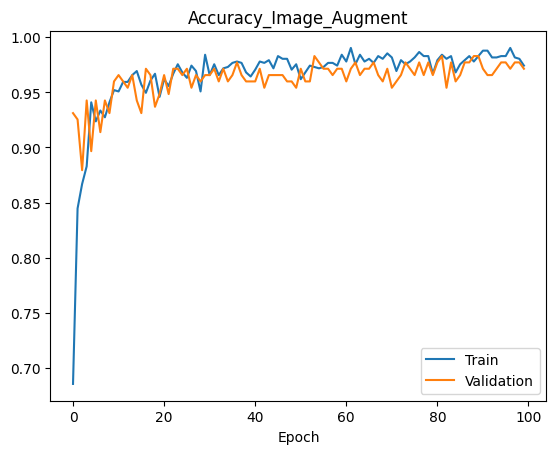

In [31]:
# model 4: add Image augmentation
# accuracy curve

# plt.style.use('seaborn-whitegrid')

train_accuracy_combined = history4.history['accuracy'] + history4_additional.history['accuracy'] + history4_additional2.history['accuracy']
val_accuracy_combined = history4.history['val_accuracy'] + history4_additional.history['val_accuracy'] +history4_additional2.history['val_accuracy']
plt.plot(train_accuracy_combined , label='Train')
plt.plot(val_accuracy_combined, label='Validation')
plt.title('Accuracy_Image_Augment')
plt.xlabel('Epoch')
plt.legend()
plt.show()

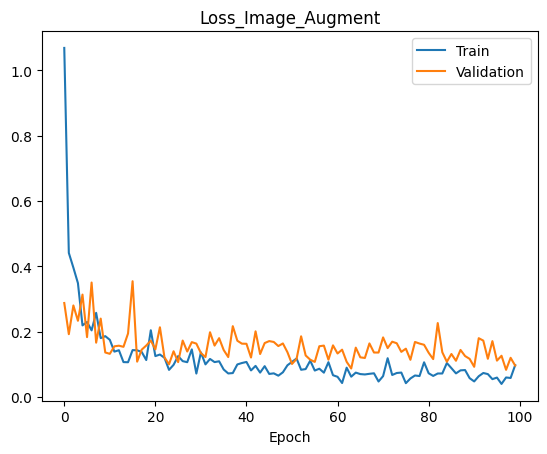

In [32]:
# model 4: add Image augmentation
# loss curve

# plt.style.use('seaborn-whitegrid')

train_loss_combined = history3.history['loss'] + history3_additional.history['loss'] + history3_additional2.history['loss']
val_loss_combined = history3.history['val_loss'] + history3_additional.history['val_loss'] + history3_additional2.history['val_loss']
plt.plot(train_loss_combined , label='Train')
plt.plot(val_loss_combined, label='Validation')
plt.title('Loss_Image_Augment')
plt.xlabel('Epoch')
plt.legend()
plt.show()